In [1]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import os
from PIL import Image
import numpy as np
from tqdm.auto import tqdm  # これを追加

DATA_DIR = './'
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train')
LABELS_CSV = os.path.join(DATA_DIR, 'train_labels.csv')
TEST_IMG_DIR = os.path.join(DATA_DIR, 'test')

# データ拡張（学習時のみ）
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class PCamDataset(Dataset):
    def __init__(self, img_dir, labels_df, transform=None):
        self.img_dir = img_dir
        self.labels = labels_df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        img_id = self.labels.iloc[idx, 0]
        label = self.labels.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, f"{img_id}.tif")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

labels_df = pd.read_csv(LABELS_CSV)
train_df, val_df = train_test_split(labels_df, test_size=0.1, random_state=42, stratify=labels_df['label'])

train_dataset = PCamDataset(TRAIN_IMG_DIR, train_df, train_transform)
val_dataset = PCamDataset(TRAIN_IMG_DIR, val_df, val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

resnet50.fc = nn.Linear(resnet50.fc.in_features, 1)
model = resnet50.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# EarlyStopping & モデル保存
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='best_model_weights.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_model = None
        self.path = path

    def __call__(self, val_acc, model):
        score = val_acc
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        '''ベストモデルを保存'''
        torch.save(model.state_dict(), self.path)
        # deepcopy して参照を切る
        self.best_model = copy.deepcopy(model.state_dict())
        if self.verbose:
            print(f'Validation accuracy improved → saving model to {self.path}')


In [ ]:

early_stopping = EarlyStopping(patience=7, verbose=True)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # エポックのプログレスバー (バッチ単位)
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [train]", leave=False)
    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        # バーに現在の loss を表示
        train_bar.set_postfix({'batch_loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # 検証 (プログレスバー付き)
    model.eval()
    val_preds = []
    val_labels = []
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [val]", leave=False)
    with torch.no_grad():
        for images, labels in val_bar:
            images = images.to(device)
            labels = labels.float().to(device)
            outputs = model(images).squeeze()
            preds = torch.sigmoid(outputs) > 0.5
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            # バーにダミー情報（バッチ数など）を出す
            val_bar.set_postfix({})

    val_acc = accuracy_score(val_labels, val_preds)
    print(f'Val Accuracy: {val_acc*100:.2f}%')
    early_stopping(val_acc, model)
    if early_stopping.early_stop:
        print('Early stopping!')
        break

# 最良モデル復元（メモリ上）
if early_stopping.best_model is not None:
    model.load_state_dict(early_stopping.best_model)
# 最良モデルはすでにファイルにも保存されているはず
torch.save(model.state_dict(), 'best_model_weights.pth')

# テストデータ予測（TTA: 画像反転で平均化） — プログレスバー付き
test_img_names = sorted(os.listdir(TEST_IMG_DIR))
test_preds = []
test_bar = tqdm(test_img_names, desc="TTA Prediction", leave=True)
model.eval()
for img_name in test_bar:
    img_path = os.path.join(TEST_IMG_DIR, img_name)
    img = Image.open(img_path).convert('RGB')
    tensors = []
    for flip in [None, 'H', 'V']:
        aug_img = img
        if flip == 'H':
            aug_img = img.transpose(Image.FLIP_LEFT_RIGHT)
        elif flip == 'V':
            aug_img = img.transpose(Image.FLIP_TOP_BOTTOM)
        tensor = val_transform(aug_img).unsqueeze(0).to(device)
        tensors.append(tensor)
    with torch.no_grad():
        outputs = [torch.sigmoid(model(t)).item() for t in tensors]
        pred = np.mean(outputs)
        test_preds.append(pred)

    # 進捗バーに現在の予測（最後の one）を表示
    test_bar.set_postfix({'last_pred': f'{pred:.4f}'})


In [3]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデル定義（学習時と同じ）
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 1)  # 1ユニット出力
model = model.to(device)

# 重みロード
ckpt_path = "/mnt/data1/gotou/Medical/b4us/kaggledata/best_model_weights.pth"
state_dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print(f"Loaded model from {ckpt_path}")


Loaded model from /mnt/data1/gotou/Medical/b4us/kaggledata/best_model_weights.pth


In [4]:
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        preds = (torch.sigmoid(outputs) > 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)
print(f"Validation Accuracy: {correct/total*100:.2f}%")


Validation Accuracy: 98.11%


In [5]:
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import numpy as np
import gc

# ===== 設定 (学習時の正規化と一致させる) =====
MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
mean = torch.tensor(MEAN).view(1,3,1,1).to(device)
std  = torch.tensor(STD).view(1,3,1,1).to(device)

def denormalize(x):
    return x * std + mean  # normalized -> pixel [0,1]

def renormalize(x):
    return (x - mean) / std

# ===== FGSM: ピクセル単位での摂動を与える関数（バッチ単位） =====
def fgsm_attack_pixel_batch(model, images, labels, epsilon_pixel):
    """
    images: normalized tensor [B,C,H,W]
    labels: tensor [B] (0/1), dtype float or long
    returns: preds_on_adv (tensor of 0/1)
    """
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    images.requires_grad = True

    outputs = model(images).squeeze(1)   # [B]
    loss = F.binary_cross_entropy_with_logits(outputs, labels.float())
    model.zero_grad()
    loss.backward()

    # grad sign in normalized space
    grad_sign = images.grad.data.sign()

    # convert pixel epsilon -> normalized-space epsilon per channel
    eps_norm = (epsilon_pixel / std).to(images.dtype)

    adv_images = images + eps_norm * grad_sign
    # clamp in pixel space
    adv_pixel = denormalize(adv_images)
    adv_pixel = torch.clamp(adv_pixel, 0.0, 1.0)
    adv_images = renormalize(adv_pixel)

    with torch.no_grad():
        adv_out = model(adv_images).squeeze(1)
        adv_probs = torch.sigmoid(adv_out)
        adv_preds = (adv_probs > 0.5).long().cpu()

    # cleanup
    images.requires_grad = False
    del images, adv_images, adv_pixel, outputs, adv_out, grad_sign, eps_norm, loss
    torch.cuda.empty_cache()
    return adv_preds

# ===== 評価ループ（バッチ実行、OOM時は1サンプル実行にフォールバック） =====
def evaluate_clean_and_fgsm(model, dataloader, epsilons=[0.01, 0.03, 0.1], per_sample_fallback=True):
    model.eval()

    # --- クリーン精度 ---
    correct = 0
    total = 0
    for images, labels in tqdm(dataloader, desc="Clean Eval"):
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()
        correct += (preds.cpu() == labels.long().cpu()).sum().item()
        total += labels.size(0)
    clean_acc = correct / total if total > 0 else 0.0
    print(f"Clean Accuracy: {clean_acc*100:.2f}%")

    # --- FGSM for each epsilon ---
    for eps in epsilons:
        adv_correct = 0
        adv_total = 0
        print(f"\nRunning FGSM with epsilon (pixel) = {eps} ...")

        # Try batch processing first
        try:
            for images, labels in tqdm(dataloader, desc=f"FGSM eps={eps}", leave=False):
                try:
                    adv_preds = fgsm_attack_pixel_batch(model, images, labels, eps)
                except RuntimeError as e:
                    # if OOM inside batch function, raise to outer to trigger fallback
                    raise e
                adv_correct += (adv_preds == labels.long().cpu()).sum().item()
                adv_total += labels.size(0)
            adv_acc = adv_correct / adv_total if adv_total > 0 else 0.0
            print(f"FGSM Accuracy (eps={eps}): {adv_acc*100:.2f}%")
        except RuntimeError as e:
            # OOM or other runtime error -> fallback to per-sample processing if enabled
            print("Batch FGSM failed (likely OOM).", str(e))
            if not per_sample_fallback:
                raise
            print("Falling back to per-sample FGSM (slower but lower memory).")
            # per-sample loop
            adv_correct = 0
            adv_total = 0
            for images, labels in tqdm(dataloader, desc=f"FGSM per-sample eps={eps}", leave=False):
                B = images.size(0)
                for i in range(B):
                    img = images[i:i+1].to(device)
                    lbl = labels[i:i+1].to(device)
                    img.requires_grad = True
                    outputs = model(img).squeeze(1)
                    loss = F.binary_cross_entropy_with_logits(outputs, lbl.float())
                    model.zero_grad()
                    loss.backward()
                    grad_sign = img.grad.data.sign()
                    eps_norm = (eps / std).to(img.dtype)
                    adv_img = img + eps_norm * grad_sign
                    adv_pixel = denormalize(adv_img)
                    adv_pixel = torch.clamp(adv_pixel, 0.0, 1.0)
                    adv_img = renormalize(adv_pixel)
                    with torch.no_grad():
                        adv_out = model(adv_img).squeeze(1)
                        adv_pred = (torch.sigmoid(adv_out) > 0.5).long().cpu().item()
                    adv_correct += (adv_pred == int(lbl.cpu().item()))
                    adv_total += 1
                    # cleanup
                    del img, lbl, outputs, loss, grad_sign, adv_img, adv_pixel, adv_out
                    torch.cuda.empty_cache()
            adv_acc = adv_correct / adv_total if adv_total > 0 else 0.0
            print(f"FGSM (per-sample) Accuracy (eps={eps}): {adv_acc*100:.2f}%")

    # final
    print("\nDone.")

# ===== 実行例 =====
# dataloader は val_loader (normalized transforms) を渡してください
evaluate_clean_and_fgsm(model, val_loader, epsilons=[0.01, 0.03, 0.1])


Clean Eval:   0%|          | 0/688 [00:00<?, ?it/s]

Clean Accuracy: 98.11%

Running FGSM with epsilon (pixel) = 0.01 ...


FGSM eps=0.01:   0%|          | 0/688 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x71b1dc70b910><function _MultiProcessingDataLoaderIter.__del__ at 0x71b1dc70b910><function _MultiProcessingDataLoaderIter.__del__ at 0x71b1dc70b910>


Traceback (most recent call last):
  File "/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
      File "/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in:   File "/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()        <function _MultiProcessingDataLoaderIter.__del__ at 0x71b1dc70b910>
self._shutdown_workers()self._shutdown_workers()

  File "/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/torch/ut

FGSM Accuracy (eps=0.01): 35.39%

Running FGSM with epsilon (pixel) = 0.03 ...


FGSM eps=0.03:   0%|          | 0/688 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x71b1dc70b910><function _MultiProcessingDataLoaderIter.__del__ at 0x71b1dc70b910><function _MultiProcessingDataLoaderIter.__del__ at 0x71b1dc70b910><function _MultiProcessingDataLoaderIter.__del__ at 0x71b1dc70b910>



Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    

FGSM Accuracy (eps=0.03): 56.11%

Running FGSM with epsilon (pixel) = 0.1 ...


FGSM eps=0.1:   0%|          | 0/688 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x71b1dc70b910>Exception ignored in: Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x71b1dc70b910>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x71b1dc70b910>
<function _MultiProcessingDataLoaderIter.__del__ at 0x71b1dc70b910>  File "/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):


      File "/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
self._shutdown_workers()  File "/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      File "/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/torch/utils/data/dataloader

KeyboardInterrupt: 

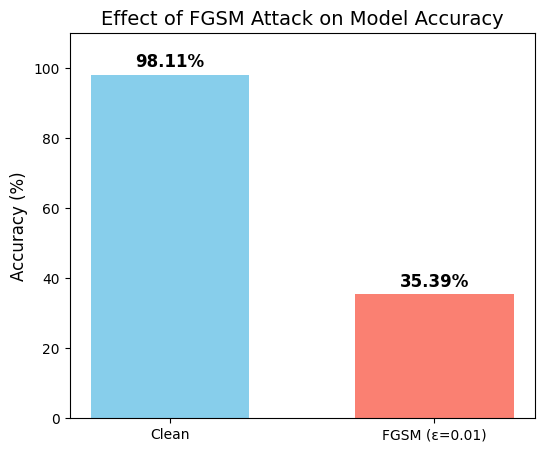

In [ ]:
import matplotlib.pyplot as plt

# 精度データ
accuracies = [98.11, 35.39]
labels = ["Clean", "FGSM (ε=0.01)"]

# 棒グラフ
plt.figure(figsize=(6,5))
bars = plt.bar(labels, accuracies, color=["salmon", "skyblue"], width=0.6)

# 数値ラベルを上に表示
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f"{height:.2f}%", 
             ha="center", va="bottom", fontsize=12, fontweight="bold")

plt.ylim(0, 110)  # 上に余白を持たせる
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Effect of FGSM Attack on Model Accuracy", fontsize=14)

plt.show()
